In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("data/names.txt").read().split()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars  = sorted(list(set("".join(words))))
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 8

def build_dataset(words):
    
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim ==2:
                #N,C
                dim = 0
            elif x.ndim ==3:
                #N,L,C
                dim = (0,1)
            xmean = x.mean(dim,keepdim=True)
            xvar = x.var(dim,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma*xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*xmean + self.momentum*self.running_mean
                self.running_var = (1-self.momentum)*xvar + self.momentum*self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [7]:
torch.manual_seed(42)

In [8]:
n_embed = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2),Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size), 
])
with torch.no_grad():
    # last layer make less confident
    model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


76579


In [9]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0, 16, 15, 18, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 12,  1, 25,  1, 14, 14]])

In [10]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [11]:
logits.shape

torch.Size([4, 27])

In [12]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [13]:
print(model.layers[0].out.shape)
print(model.layers[1].out.shape)
print(model.layers[2].out.shape)
(torch.randn(4, 2, 20) @ torch.randn(20,200) + torch.randn(200)).shape

torch.Size([4, 8, 24])
torch.Size([4, 4, 48])
torch.Size([4, 4, 128])


torch.Size([4, 2, 200])

In [14]:
e = torch.randn(4,8,10)
expl = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
(e.view(4,4,20) == expl).all()

tensor(True)

In [15]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = 0.1 if i < 100000 else 0.01
    lr = 1 if i < 100000 else 0.1 #bumb up lr becasue of batch norm
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    

      0/ 200000: 3.3226
  10000/ 200000: 2.2083
  20000/ 200000: 2.1852
  30000/ 200000: 2.1773
  40000/ 200000: 2.2639
  50000/ 200000: 2.4212
  60000/ 200000: 2.3826
  70000/ 200000: 2.1344
  80000/ 200000: 1.9250
  90000/ 200000: 2.2887
 100000/ 200000: 2.0044
 110000/ 200000: 1.9639
 120000/ 200000: 1.2482
 130000/ 200000: 1.6118
 140000/ 200000: 1.7053
 150000/ 200000: 2.1026
 160000/ 200000: 1.9435
 170000/ 200000: 2.3812
 180000/ 200000: 1.6793
 190000/ 200000: 2.1863


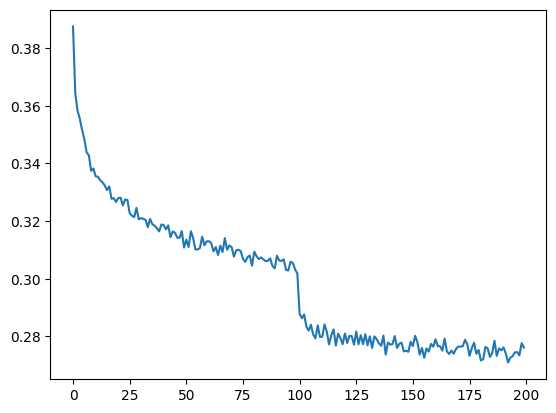

In [17]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [18]:
for layer in model.layers:
    layer.training = False

In [19]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xva,Yva),
        'test': (Xte,Yte)
    }[split]
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.8761680126190186
val 2.024538993835449


In [20]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]  + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

uaeli.
eliyana.
amechas.
mylas.
calinbi.
malayah.
daveon.
lucke.
marika.
bexleigh.
evon.
sharvey.
knistyn.
khamir.
michael.
ekwast.
thmerin.
anyala.
rioge.
raelie.


In [21]:
#next
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [23]:
logits=model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [24]:
#forward all
logits = torch.zeros(8,27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

convolution is a “for loop”

allows to forward linear layers efficiently over space